# EDA

Thanks to the great notebook's: 
- https://www.kaggle.com/code/lextoumbourou/feedback3-eda-hf-custom-trainer-sift
- https://www.kaggle.com/code/ryanluoli2/simple-text-analysis-to-start-with
- https://www.kaggle.com/code/egorsheremetov3/bert-defined-for-every-feature



In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords
from collections import defaultdict
from IPython.core.display import display, HTML

from sklearn.feature_extraction.text import CountVectorizer

### Evaluation:
Submissions are scored using MCRMSE, mean columnwise root mean squared error:
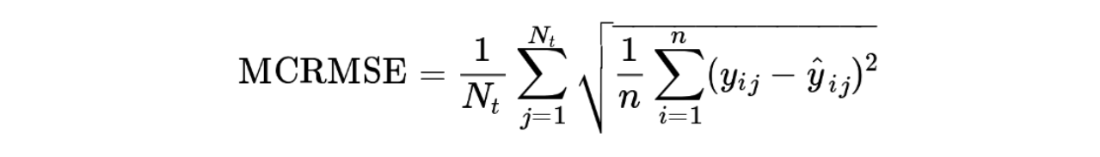

In [2]:
def mcrmse(targets, predictions):
    error = targets - predictions
    squared_error = np.square(error)
    colwise_mse = np.mean(squared_error, axis=0)
    root_colwise_mse = np.sqrt(colwise_mse)
    return np.mean(root_colwise_mse, axis=0)

### Import Data

In [3]:
df_train = pd.read_csv('input/train.csv')
df_test = pd.read_csv('input/test.csv')
submission = pd.read_csv('input/sample_submission.csv')

In [4]:
df_train["full_text"].iloc[3]

'The best time in life is when you become yourself. I agree that the greatest accomplishment, is when you be yourself in a world that constantly trying to make you something else. Because you make your own choices, you become more happy, and you respect others.\n\nFirst, you make your own choices by being yourself. Becoming yourself means that you should be able to make your own choices and not be shy or afraid of what you\'re doing. Because you\'re defining yourself by doing those things that you want. Some people follow others, therefore, they don\'t make their own choices. People are afraid to make their own choice because they don\'t want to get rejected or be wrong. In this world, most of the teenagers act and follow the people who are strong and bullies. The reason they follow them and make the same choices they make, is because they\'re afraid that they will get beaten up and be left out. Personally when I came to the United States I used to follow other, because I thought they 

In [5]:
df_train.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5


In [6]:
len(df_train)

3911

### Output Variables

In [7]:
df_train.columns

Index(['text_id', 'full_text', 'cohesion', 'syntax', 'vocabulary',
       'phraseology', 'grammar', 'conventions'],
      dtype='object')

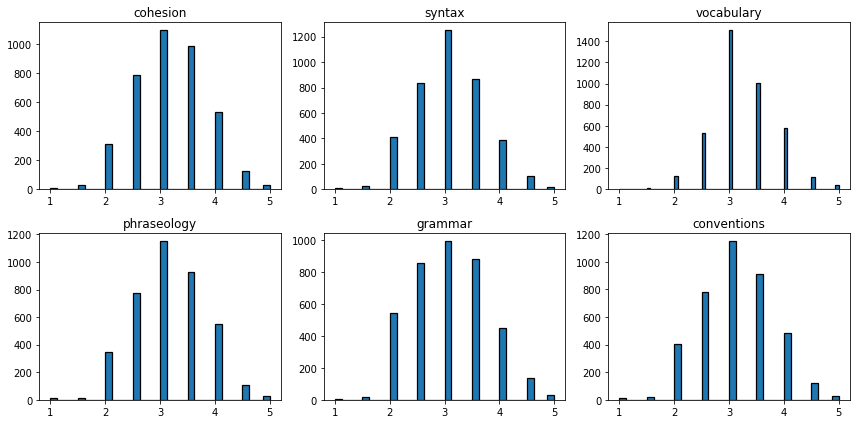

In [8]:
# Distribution

targets = ['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']

fig, axes = plt.subplots(2, len(targets)//2, figsize=(12,6))

for i, target in enumerate(targets):
    ax = axes.flat[i]
    sns.histplot(x=target, data=df_train, linewidth=1.25, alpha=1, ax=ax, zorder=2)
    ax.set_title(target)
    ax.set(xlabel=None, ylabel=None)
    
fig.suptitle('')
plt.tight_layout()
plt.show()

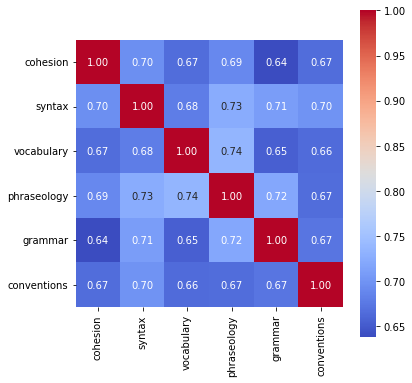

In [9]:
# Correlation

corr = df_train[targets].corr()
fig, ax = plt.subplots(figsize=(6,6))        
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, square=True, annot=True, cmap="coolwarm", fmt=".2f")
plt.show()

In [10]:
# Function pretty printer
def print_texts(df):
    inner_html = ""
    for idx, row in df.iterrows():
        inner_html += f"""
        <td style="vertical-align:top; border-right: 1px solid #7accd8">
        <h3 style="text-align:left">{row.text_id}</h3>
        <hr>
            <dl>
                <dt>Cohesion Syntax Vocabulary Phraseology Grammar Conventions</dt>
                <dd>{row.cohesion} {row.syntax} {row.vocabulary} {row.phraseology} {row.grammar} {row.conventions}</dd>
            </dl>
            
            <hr>
            <p>
            {row.full_text[:500]}
            </p>
        </td>
        """
    display(HTML(f"""
    <table style="font-family: monospace;">
        <tr>
             {inner_html}
        </tr>
    </table>
    """))

In [11]:
# Lowest vs Highest Scores
df_train['total_score'] = df_train[targets].sum(axis=1)
lowest = df_train.sort_values('total_score').head(2)
print_texts(lowest)

df_train['total_score'] = df_train[targets].sum(axis=1)
highest = df_train.sort_values('total_score', ascending=False).head(2)
print_texts(highest)

767533E12569 Cohesion Syntax Vocabulary Phraseology Grammar Conventions 1.0 1.0 1.0 1.0 1.0 1.0 he is a good because they are the prescient and us. now the are more procession a other prescient and us. because and the more many education for student and school. the more school for one because he have a one women the have many education for a other because the good more the one is information for access because is not like the brazen giant of Greek fame with conquering one nation for is the imprison the eyes command the one book for people the us give more your lied your huddled Farmer with,48EA282A4EAF Cohesion Syntax Vocabulary Phraseology Grammar Conventions 1.0 1.0 1.0 1.0 1.0 1.0 some student offer distance learning as an option for student to attend classes from homr by wat of online pr video conferencing. i think student would benefit form being able to attend classesfrom home. you are authorized take the electronic version of this you will taking this promptsome student offer distance learning as an option for student to attend classes from homr by wat of online pr video conferencing. some student offer distance learning as an option for student to attend classes from


"B1AFACE6704E Cohesion Syntax Vocabulary Phraseology Grammar Conventions 5.0 5.0 5.0 5.0 5.0 5.0 I agree with Michelangelo's statement as I have found through experience that it benefits me more to set high expectations and not reach my goal, rather than settling on a low goal and achieving it. When setting high goals, I find that I learn more and progress my abilties further than I do with a lower goal. This is because setting high goals requires confidence, challenges, and pride. Firstly, hard work is required to achieve high goals, and requires confidence. Confidence involves having tru","52DC3B7C3952 Cohesion Syntax Vocabulary Phraseology Grammar Conventions 5.0 5.0 4.5 5.0 5.0 5.0 Working From Home Should students be allowed to attend classes from home? I agree that attending classes while at home would be beneficial for many people and can actually help them work better. One reason is that it would be less stressful for the student and put a lot less pressure into getting the work done. Another reason is that it would give them more time to work, for example they could relax and take little breaks while working instead of having to cram all that work into one class sess"


### Text Analysis

Number of Characters

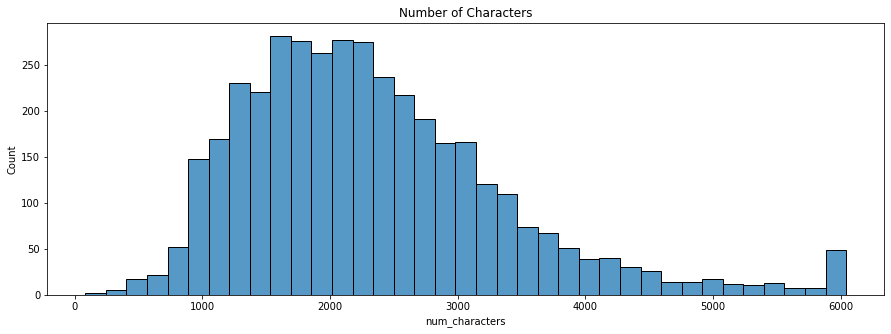

In [12]:
fig = plt.figure(figsize=(15, 5))
df_train['num_characters'] = df_train['full_text'].str.len()
sns.histplot(data=df_train, x="num_characters")
plt.title("Number of Characters")
plt.show()

In [13]:
fig = px.histogram(df_train, x = df_train['full_text'].str.len(), marginal="box", 
                   title = "Number of Characters", color_discrete_sequence=["#FFA200"])
fig.update_layout(bargap=0.2)
fig.update_layout(template="plotly_dark", font=dict(family="PT Sans", size=18, color="#C4FEFF"))
fig.show()

Number of Words

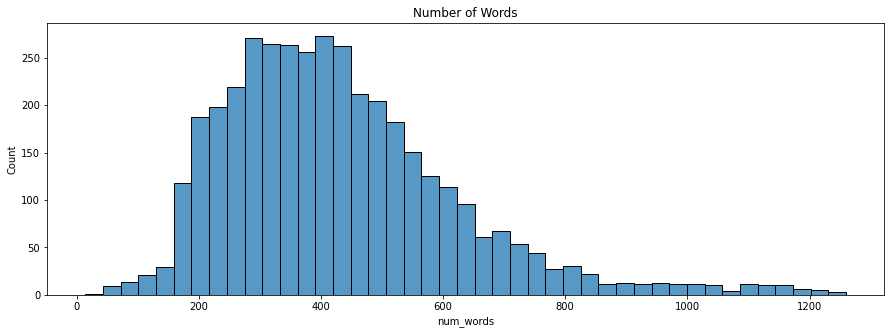

In [14]:
fig = plt.figure(figsize=(15, 5))
df_train['num_words'] = df_train['full_text'].apply(lambda x: len(x.split()))
#df_train['num_words'] = df_train['full_text'].str.split().map(lambda x: len(x))
sns.histplot(data=df_train, x="num_words")
plt.title("Number of Words")
plt.show()

In [15]:
fig = px.histogram(df_train, x = df_train['num_words'], marginal="box", 
                   title = "Number of Words", color_discrete_sequence=["#FFA200"])
fig.update_layout(bargap=0.2)
fig.update_layout(template="plotly_dark", font=dict(family="PT Sans", size=18, color="#C4FEFF"))
fig.show()

In [16]:
df_train['num_words'].describe()

count    3911.000000
mean      430.492969
std       191.868449
min        14.000000
25%       294.000000
50%       402.000000
75%       526.500000
max      1260.000000
Name: num_words, dtype: float64

Average Word Length

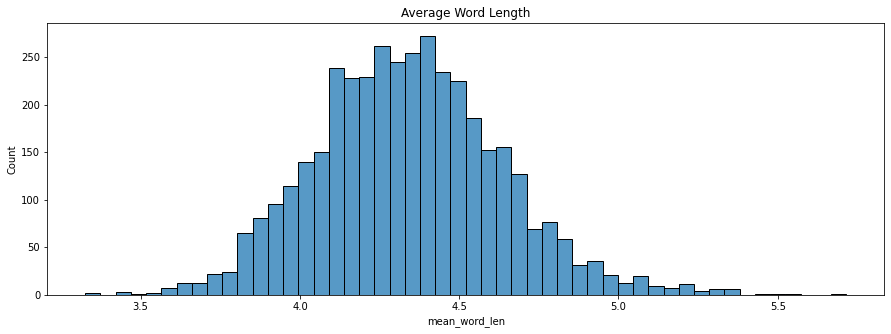

In [17]:
fig = plt.figure(figsize=(15, 5))
df_train['mean_word_len'] = df_train['full_text'].str.split().apply(lambda x : np.mean([len(i) for i in x]))
sns.histplot(data=df_train, x="mean_word_len")
plt.title("Average Word Length")
plt.show()

In [18]:
fig = px.histogram(df_train, x=df_train['mean_word_len'], marginal="box", 
                   title = "Average Word Length", color_discrete_sequence=["#FFA200"])
fig.update_layout(bargap=0.2)
fig.update_layout(template="plotly_dark", font=dict(family="PT Sans", size=18, color="#C4FEFF"))
fig.show()

Common Stopwords

In [19]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

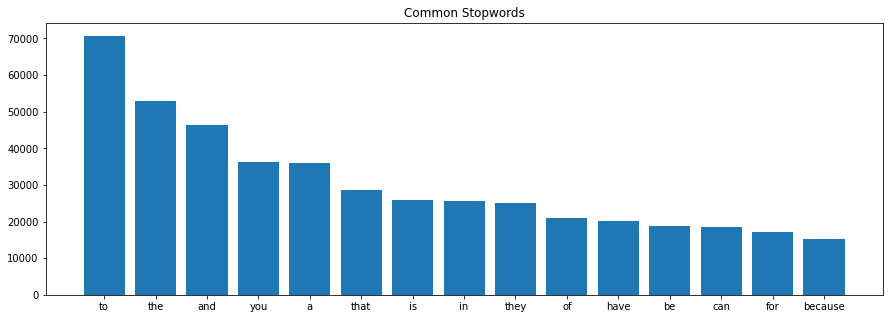

In [20]:
fig = plt.figure(figsize=(15, 5))

stop_words = set(stopwords.words('english'))
corpus = ''.join(df_train.full_text).split()

dic = defaultdict(int)
for word in corpus:
    if word in stop_words:
        dic[word] += 1
top_words = sorted(dic.items(), key=lambda x:x[1], reverse=True)[:15] 
x, y = zip(*top_words)
plt.bar(x, y)
plt.title('Common Stopwords')
plt.show()

Common Words

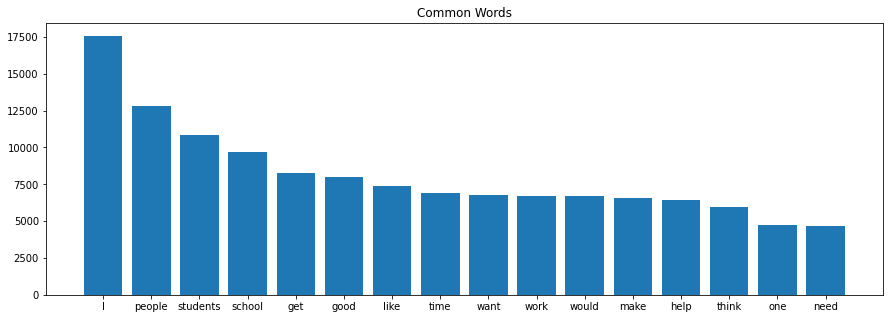

In [21]:
fig = plt.figure(figsize=(15, 5))

counter = Counter(corpus)
words = counter.most_common()

x, y = [], []
i = 0
for word, count in words:
    if (word not in stop_words):
        x.append(word)
        y.append(count)  
        i += 1
    if i > 15:
        break
plt.bar(x, y)
plt.title('Common Words')
plt.show()

WordCloud

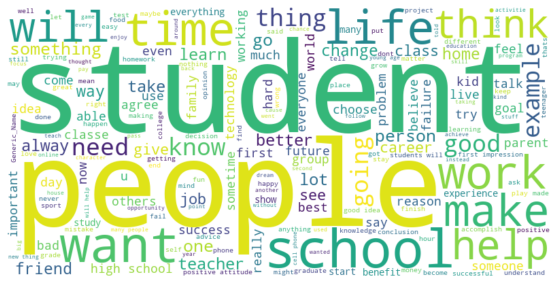

In [22]:
wordcloud = WordCloud(background_color='white', width=800, height=400).generate(''.join(df_train.full_text))

plt.figure(figsize=(20, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

2-grams Analysis

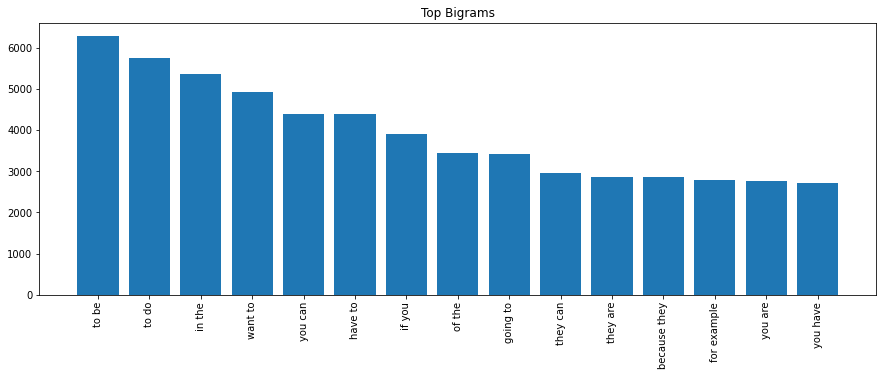

In [23]:
fig = plt.figure(figsize=(15, 5))

def get_top_bigrams(corpus, n):
    vectorizer = CountVectorizer(ngram_range=(n,n)).fit(corpus)
    bag_of_words = vectorizer.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq

top_bigrams = get_top_bigrams(df_train['full_text'], n=2)[:15]
x, y = map(list, zip(*top_bigrams))
plt.bar(x, y)
plt.title('Top Bigrams')
plt.xticks(rotation=90)
plt.show()

# MODELING

In [24]:
import spacy

from tqdm.notebook import tqdm
import random

from sklearn.model_selection import train_test_split

In [25]:
import os
import gc

In [26]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 4.7 MB/s 
     |████████████████████████████████| 182 kB 96.4 MB/s 
     |████████████████████████████████| 7.6 MB 59.1 MB/s 


In [27]:
import torch
from torch import nn

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler


from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import AdamW, get_linear_schedule_with_warmup

In [28]:
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: A100-SXM4-40GB


In [29]:
BASE_URL = "input"
PREDICTABLE = ['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [30]:
data_df = pd.read_csv(os.path.join(BASE_URL, 'train.csv'))

In [31]:
len(data_df)

3911

In [32]:
data_df.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5


In [33]:
X = data_df[["text_id", "full_text"]]
y = data_df[PREDICTABLE]

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [35]:
train_df = X_train
train_df[PREDICTABLE] = y_train

In [36]:
test_df = X_test
test_df[PREDICTABLE] = y_test

In [37]:
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [38]:
# Issue with vocabulary only one value = 1 in the class
df_aux = train_df[train_df["vocabulary"]==1]
train_df = train_df.append(df_aux, ignore_index=True)

In [39]:
class TextDatasetTransformer(object):
    
     def __init__(self, max_length: int = 256, batch_size: int = 4):        
         self.tokenizer = AutoTokenizer.from_pretrained(
             'drive/MyDrive/Colab Notebooks/transformers-v2/bert-large-cased/',
             do_lower_case=False,
             local_files_only=True,
             tokenizer_type='bert'
         )
         self.max_length = max_length
         self.batch_size = batch_size
        
        
     def train_transform(self, df: pd.DataFrame, predictable_column: str):
         train = self._generate_train_df(df, predictable_column)
         X_train, X_val, y_train, y_val = train_test_split(
                                                   train.text.values, 
                                                   train[[x for x in train.columns if x not in ['text', 'label']]].values,
                                                   test_size=0.15, 
                                                   random_state=42, 
                                                   stratify=train.label.values)
         return X_train, X_val, y_train, y_val
    
    
     def tokenize(self, data: np.array):                                   
         encoded_data = self.tokenizer.batch_encode_plus(
             data, 
             add_special_tokens=True, 
             return_attention_mask=True, 
             max_length=self.max_length, 
             padding='max_length', 
             truncation=True,
             return_tensors='pt'
         )
         input_ids = encoded_data['input_ids']
         attention_mask = encoded_data['attention_mask']
         return input_ids, attention_mask
    
    
     def get_dataloader(self, input_ids, attention_mask, labels):
         labels_tensor = torch.tensor(labels)
         dataset = TensorDataset(input_ids, attention_mask, labels_tensor)
         dataloader = DataLoader(dataset, sampler=RandomSampler(dataset), batch_size=self.batch_size)
         return dataloader
    
    
     def _generate_train_df(self, df: pd.DataFrame, predictable_column: str) -> pd.DataFrame:
         df_train = df[['full_text', predictable_column]]
         df_train.columns = ['text', 'label']
         df_train[[str(x) for x in np.arange(1.0, 5.5, 0.5)]] = 0 * len(df_train)
         for i, x in enumerate(df_train.label):
             df_train[str(x)][i] = 1
         return df_train

In [40]:
 class ModelPipeline(object):
    
     def __init__(self, model: str):
         self.model_name = 'drive/MyDrive/Colab Notebooks/transformers-v2/bert-large-cased/'
         self.model = None
    
    
     def train(self, dataloader, num_labels: int = 2, epoches: int = 3):
         self.model = self.get_model(model_name=self.model_name, num_labels=num_labels)
         optimizer = self.get_optimizer(self.model)
         scheduler = self.get_scheduler(optimizer, len(dataloader)*epoches)
    
    
     def predict(self):
         pass
    
    
     def get_model(self, model_name: str = 'drive/MyDrive/Colab Notebooks/transformers-v2/bert-large-cased/', num_labels: int = 2):
         model = AutoModelForSequenceClassification.from_pretrained(
             'drive/MyDrive/Colab Notebooks/transformers-v2/bert-large-cased/',
             # len(train.grammar.unique())
             num_labels=9,
             output_attentions=False,
             output_hidden_states=False,
             local_files_only=True,
             model_type='bert')
         model.cuda()
         return model
    
    
     def get_optimizer(self, model, learning_rate=1e-5, eps=1e-8):
         optimizer = AdamW(model.parameters(), lr=learning_rate, eps=eps)
         return optimizer
    
    
     def get_scheduler(self, optimizer, training_steps: int):
         scheduler = get_linear_schedule_with_warmup(
             optimizer, 
             num_warmup_steps=0,
             # len(dataloader_train)*epochs)
             num_training_steps=training_steps)
         return scheduler

In [41]:
class RMSELoss(nn.Module):
     def __init__(self, eps=1e-6):
         super().__init__()
         self.mse = nn.MSELoss()
         self.eps = eps

     def forward(self, yhat, y):
         loss = torch.sqrt(self.mse(yhat, y) + self.eps)
         return loss


class MCRMSELoss(nn.Module):
     def __init__(self, num_scored=3):
         super().__init__()
         self.rmse = RMSELoss()
         self.num_scored = num_scored

     def forward(self, yhat, y):
         score = 0
         for i in range(self.num_scored):
             score += self.rmse(yhat[:, i], y[:, i]) / self.num_scored
         return score

In [42]:
 class Pipeline(object):
    
     def __init__(self, max_length=512, batch_size=8):
         self.data_transformer = TextDatasetTransformer(max_length=max_length, batch_size=batch_size)
         self.model_pipeline = ModelPipeline('drive/MyDrive/Colab Notebooks/transformers-v2/bert-large-cased/')
         self.values_dict =  {k: v for k,v in zip([x for x in range(0, 9)], [x for x in np.arange(1.0, 5.5, 0.5)])}

     def train(self, df: pd.DataFrame, predictable_column: str, epochs: int = 5):
         print("Split Data Transform...")
         X_train, _, y_train, _ = self.data_transformer.train_transform(df, predictable_column)
        
         print("Tokenization...")
         input_ids_train, attention_mask_train = self.data_transformer.tokenize(list(X_train))
        
         print("Generate DataLoader...")
         dataloader_train = self.data_transformer.get_dataloader(input_ids_train, attention_mask_train, y_train)
        
         print("Prepare Model...")
         model = self.model_pipeline.get_model(num_labels=len(df[predictable_column].unique()))
         optimizer = self.model_pipeline.get_optimizer(model)
         scheduler = self.model_pipeline.get_scheduler(optimizer, len(dataloader_train)*epochs)
        
         print("Train...")
         for epoch in tqdm(range(1, epochs+1)):
    
             model.train()

             loss_train_total = 0

             progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
             for batch in progress_bar:

                 model.zero_grad()

                 input_ids_batch = batch[0].to(device)
                 attention_mask_batch = batch[1].to(device)
                 labels_batch = batch[2].to(device).float()

                 inputs = {
                     'input_ids':      input_ids_batch,
                     'attention_mask': attention_mask_batch,
                     'labels':         labels_batch}       

                 outputs = model(**inputs)

                 loss = outputs[0]
                 loss_train_total += loss.item()
                 loss.backward()
                                
                 torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

                 optimizer.step()
                 scheduler.step()

                 progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})

             tqdm.write(f'\nEpoch {epoch}')

             loss_train_avg = loss_train_total / len(dataloader_train)
             tqdm.write(f'Training loss: {loss_train_avg}')
            
             gc.collect()
             torch.cuda.empty_cache()
        
         print("Return Trained Model...")
         return model
        
     def predict(self, model, df: pd.DataFrame, predictable_column: str):
        
         model.eval()
        
         print("Prepare Test Data...")
         input_ids, attention_mask = self.data_transformer.tokenize(list(df.full_text.values))
         inputs = {
             'input_ids':      input_ids.to(device),
             'attention_mask': attention_mask.to(device)
         }       
        
         print("Make Test Predictions...")
         outputs = model(**inputs)
         np_outputs = np.array(outputs.logits.detach().cpu())
               
         df[predictable_column] = [x.argmax() for x in np_outputs]
         df[predictable_column] = df[predictable_column].apply(lambda x: self.values_dict[x])
         return df

In [43]:
model = None

del model
gc.collect()
torch.cuda.empty_cache()

# TRAIN/VALIDATION/TEST

In [44]:
# # Train/Validation loop for each column a different BERT Large Cased Model
# #train_df_copy = train_df[['text_id', 'full_text']].copy()
# pipeline = Pipeline()
# model = None

# for pred_col in PREDICTABLE:

#     model = pipeline.train(train_df, pred_col, epochs=3)
#     os.makedirs(f'bert_model_{pred_col}')
#     model.save_pretrained(f'bert_model_{pred_col}')
    
#     del model
#     gc.collect()
#     torch.cuda.empty_cache()
   
#     #train_df_copy = pipeline.predict(model, train_df_copy, pred_col)
#     #del model
#     #gc.collect()
#     #torch.cuda.empty_cache()

#    # test_df = pipeline.predict(model, test_df, pred_col)
#    # torch.cuda.empty_cache()

# #test_df.drop('full_text', axis=1).to_csv("submission.csv", index=False)

In [45]:
# Check files

data_file = os.path.join(BASE_URL, 'test.csv')
tokenizer_dir = 'drive/MyDrive/Colab Notebooks/transformers-v2/bert-large-cased/'


assert os.path.isfile(data_file)
assert os.path.isdir(tokenizer_dir)

for col in PREDICTABLE:
    assert os.path.isdir(f'drive/MyDrive/Colab Notebooks/transformers-v2/bert_model_{col}')

In [46]:
# We use 20% of information to test the model
df_predictable = test_df 
data_to_predict = df_predictable[['text_id', 'full_text']]

In [47]:
# It transforms the values from the model to the same scale of real values (from 1 to 5 in 0.5 steps)
values_dict =  {k: v for k,v in zip([x for x in range(0, 9)], [x for x in np.arange(1.0, 5.5, 0.5)])}

In [48]:
def tokenize(tokenizer, data: np.array):                                   
    encoded_data = tokenizer.batch_encode_plus(
        data, 
        add_special_tokens=True, 
        return_attention_mask=True, 
        max_length=512, 
        padding='max_length', 
        truncation=True,
        return_tensors='pt'
    )
    input_ids = encoded_data['input_ids']
    attention_mask = encoded_data['attention_mask']
    return input_ids, attention_mask

In [49]:
tokenizer = AutoTokenizer.from_pretrained(tokenizer_dir)
for pred_col in tqdm(PREDICTABLE):
    model = AutoModelForSequenceClassification.from_pretrained(f'drive/MyDrive/Colab Notebooks/transformers-v2/bert_model_{pred_col}')
    model.cuda()
    model.eval()
        
    input_ids, attention_mask = tokenize(tokenizer, list(data_to_predict.full_text.values))
    
    dataset = TensorDataset(input_ids, attention_mask)
    dataloader = DataLoader(dataset, batch_size=8)
    
    progress_bar = tqdm(dataloader, desc='Making predictions', leave=False, disable=False)
    
    outputs_total = []
    for batch in progress_bar:
        
        input_ids_batch = batch[0].to(device)
        attention_mask_batch = batch[1].to(device)
        
        inputs = {
            'input_ids':      input_ids_batch,
            'attention_mask': attention_mask_batch
        }       

        outputs = model(**inputs)
        np_outputs = np.array(outputs.logits.detach().cpu())
        for o in np_outputs:
            outputs_total.append(o)
        
        gc.collect()
        torch.cuda.empty_cache()
    
    outputs_total = np.array(outputs_total)
    argmax_outputs = [x.argmax() for x in outputs_total]
    data_to_predict[pred_col] = argmax_outputs
    data_to_predict[pred_col] = data_to_predict[pred_col].apply(lambda x: values_dict[x])
    
    del model
    gc.collect()
    torch.cuda.empty_cache()

  0%|          | 0/6 [00:00<?, ?it/s]

Making predictions:   0%|          | 0/98 [00:00<?, ?it/s]

<ipython-input-49-0e10a9f5adba>:35: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-49-0e10a9f5adba>:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Making predictions:   0%|          | 0/98 [00:00<?, ?it/s]

Making predictions:   0%|          | 0/98 [00:00<?, ?it/s]

Making predictions:   0%|          | 0/98 [00:00<?, ?it/s]

Making predictions:   0%|          | 0/98 [00:00<?, ?it/s]

Making predictions:   0%|          | 0/98 [00:00<?, ?it/s]

In [50]:
data_to_predict.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,772D27D400BB,It god to have a possitive attitude when you d...,2.5,2.5,2.5,2.5,2.0,2.0
1,9E8F3C6405CA,Why do people ask more then one person for adv...,3.0,3.0,3.0,3.0,3.5,3.0
2,948771F795EB,"We accomplish more when we are active, and are...",3.5,3.5,3.5,3.5,3.5,3.0
3,FE14D7378CFB,Do you agree or disagree about imagination bei...,3.5,3.0,3.0,3.5,3.5,3.0
4,7AAE019F70D6,I disagree with the principal saying that all ...,3.5,3.0,3.0,3.5,3.5,3.0


In [51]:
test_df.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,772D27D400BB,It god to have a possitive attitude when you d...,3.0,2.5,2.5,2.0,2.0,2.0
1,9E8F3C6405CA,Why do people ask more then one person for adv...,3.0,2.0,3.0,3.5,3.0,3.0
2,948771F795EB,"We accomplish more when we are active, and are...",4.0,4.0,3.0,4.0,4.0,4.0
3,FE14D7378CFB,Do you agree or disagree about imagination bei...,3.0,3.0,3.5,3.0,3.5,3.5
4,7AAE019F70D6,I disagree with the principal saying that all ...,3.5,3.5,3.5,3.5,3.0,3.5


### Evaluation:
Submissions are scored using MCRMSE, mean columnwise root mean squared error:
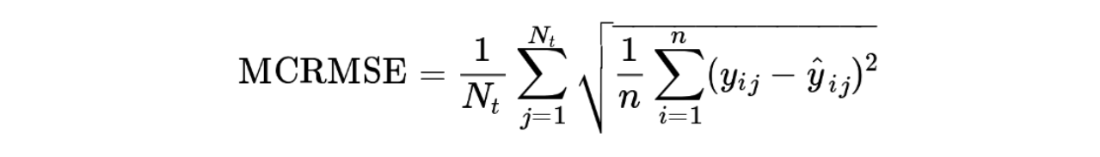

In [52]:
def mcrmse(targets, predictions):
    error = targets - predictions
    squared_error = np.square(error)
    colwise_mse = np.mean(squared_error, axis=0)
    root_colwise_mse = np.sqrt(colwise_mse)
    return np.mean(root_colwise_mse, axis=0)

In [53]:
# Comparison between predicted and real values
y_pred = data_to_predict.drop(['full_text', 'text_id'], axis=1)
y_real = test_df.drop(['full_text', 'text_id'], axis=1)
mcrmse(y_real, y_pred)

0.5243748662424114